In [1]:
using ImageMagick
using Images,ImageCore
using Random
using LinearAlgebra
using AutoGrad
using Base.Iterators: flatten
using IterTools: ncycle, takenth,take
using Statistics: mean
using MLDatasets
using ProgressMeter
import CUDA 
using Knet
using Knet: bce,adam,deconv4,Knet,accuracy,sigm,elu,update!,params,conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, minibatch, Data
array_type= CUDA.functional() ? KnetArray{Float32} : Array{Float32}


┌ Warning: Your Tesla K20m GPU does not meet the minimal required compute capability (3.5.0 < 5.0).
│ Some functionality might not work. For a fully-supported set-up, please use an older version of CUDA.jl
└ @ CUDA /kuacc/users/agharelar20/.julia/packages/CUDA/YeS8q/src/state.jl:251


KnetArray{Float32,N} where N

In [2]:
function imshow(img;nrow=2)
    img_RGB=Array{RGB{Float32},3}(undef,size(img,1),size(img,2),size(img,4))
    for z in 1:size(img,4)
        for j in 1:size(img,2)
            for i in 1:size(img,1)
                img_RGB[j,i,z]=RGB(img[i,j,1,z],img[i,j,2,z],img[i,j,3,z])
            end
    
        end
    end
   return mosaicview(img_RGB, fillvalue=1, nrow=nrow, npad=12, rowmajor=true)
    #return img_RGB   
end

imshow (generic function with 1 method)

In [3]:
function leaky_relu(x, alpha=0.1)
    pos = relu(x)
    neg = relu(-x)
    return pos + alpha * neg
end

leaky_relu (generic function with 2 methods)

In [76]:
# The function for initialization of network weight
function w_init(n...)
    return randn(n...).*0.2    
end

w_init (generic function with 1 method)

In [77]:
struct Chain
    layers
    Chain(layers...)=new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x);end; x)
(c::Chain)(x,y) = bce(c(x)[1,:],y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)
(c::Chain)(x,cc::Chain)=cc(c(x)) # Generator will accept Discriminator as input
(c::Chain)(x,y,cc::Chain) = bce(c(x,cc)[1,:],y)
(c::Chain)(d::Data,cc::Chain) = mean(c(x,y,cc) for (x,y) in d)


struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * dropout(x,d.p) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
function Dense(i::Int,o::Int,f=elu;pdrop)
    Dense(param(o,i;init=w_init,atype=array_type), param0(o;atype=array_type), f, pdrop)
end


mutable struct Dense_SN; w; b; f; p; σ ;u ;end # σ is used for storing the largest singular value of W # u is the left orthogonal vector with respect to σ
(d::Dense_SN)(x) = d.f.(d.w * dropout(x,d.p) .+ d.b) 
function Dense_SN(i::Int,o::Int,f=elu;pdrop)
    Dense_SN(param(o,i;init=w_init,atype=array_type), param0(o;atype=array_type), f, pdrop,convert(Float32,1.0), convert(array_type,randn(i)))
end


mutable struct Conv_SN; w; b; f; stride; padding; p; σ ;u ;end
(c::Conv_SN)(x) = c.f.(conv4(c.w, dropout(x,c.p);padding=c.padding,stride=c.stride) .+ c.b)
function Conv_SN(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;stride,padding,pdrop)
    Conv_SN(param(w1,w2,cx,cy;init=w_init,atype=array_type), param0(1,1,cy,1;atype=array_type), f,stride,padding, pdrop,convert(Float32,1.0), convert(array_type,randn(cy)))

end

struct Conv; w; b; f; stride; padding; p;end
(c::Conv)(x) = c.f.(conv4(c.w, dropout(x,c.p);padding=c.padding,stride=c.stride) .+ c.b)
function Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;stride,padding,pdrop)
    Conv(param(w1,w2,cx,cy;init=w_init,atype=array_type), param0(1,1,cy,1;atype=array_type), f,stride,padding, pdrop)
end


struct vec_to_img; output_dims;end # this struct is used for reshaping purposes
(v::vec_to_img)(x)=reshape(x,v.output_dims)


In [78]:
struct Conv_BN; w; w_bn; m_bn ; f ; stride; padding; p;end
function (c::Conv_BN)(x)
    x=conv4(c.w, dropout(x,c.p);padding=c.padding,stride=c.stride)
    x=batchnorm(x,c.m_bn,c.w_bn)
    x=c.f.(x)
    return x
end
function Conv_BN(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;stride,padding,pdrop)
    Conv_BN(param(w1,w2,cx,cy;init=w_init,atype=array_type),array_type(bnparams(Float32,cy)),bnmoments(), f,stride,padding, pdrop)
end
struct Deconv_BN; w ; w_bn;m_bn;f;stride; padding; p;end
function (c::Deconv_BN)(x)
    x=deconv4(c.w, dropout(x,c.p);padding=c.padding,stride=c.stride)
    x=batchnorm(x,c.m_bn,c.w_bn)
    x=c.f.(x)
end
function Deconv_BN(w1::Int,w2::Int,cy::Int,cx::Int,f=relu;stride,padding,pdrop)
    Deconv_BN(param(w1,w2,cy,cx;init=w_init,atype=array_type),array_type(bnparams(Float32,cy)),bnmoments() , f,stride,padding, pdrop)
end

Deconv_BN

In [79]:
function Spectral_normalization(c::Chain)
    for l in c.layers
        if (typeof(l)==Dense_SN || typeof(l)==Conv_SN)
            l.σ,l.u=power_iteration(l.w,l.u)
            l.w./=l.σ
           
        end
    end
end

function De_normalization(c::Chain)
    for l in c.layers
        if (typeof(l)==Dense_SN || typeof(l)==Conv_SN)
            l.w.*=l.σ
        end
    end
end

De_normalization (generic function with 1 method)

In [80]:
function power_iteration(w_,u,number_of_iteration=1)
    v=[]
    w=reshape(w_,:,size(w_)[end])
    w=w'
    for i in 1:number_of_iteration
        v=(w'*u)/norm(w'*u)
        u=(w*v)/norm(w*v)
    end
    σ=u'*w*v
    return σ,u
end

power_iteration (generic function with 2 methods)

In [81]:
D=Chain(
    Conv(3,3,3,64,leaky_relu;padding=1,stride=1,pdrop=0),
    Conv_SN(4,4,64,64,leaky_relu;padding=1,stride=2,pdrop=0),
    Conv_SN(3,3,64,128,leaky_relu;padding=1,stride=1,pdrop=0),
    Conv_SN(4,4,128,128,leaky_relu;padding=1,stride=2,pdrop=0),
    Conv_SN(3,3,128,256,leaky_relu;padding=1,stride=1,pdrop=0),
    Conv_SN(4,4,256,256,leaky_relu;padding=1,stride=2,pdrop=0),
    Conv_SN(3,3,256,512,leaky_relu;padding=1,stride=1,pdrop=0),
    vec_to_img((4*4*512,:)),
    Dense_SN(4*4*512,1,Knet.sigm;pdrop=0)
)
G=Chain(
    Dense(128,4*4*512,pdrop=0),
    vec_to_img((4,4,512,:)),
    Deconv_BN(4,4,256,512,relu;padding=1,stride=2,pdrop=0),
    Deconv_BN(4,4,128,256,relu;padding=1,stride=2,pdrop=0),
    Deconv_BN(4,4,64,128,relu;padding=1,stride=2,pdrop=0),
    Conv(3,3,64,3,Knet.tanh,padding=1,stride=1,pdrop=0),

)
disc_itrs=5
nEpoch=200
batch_size=64
latent_size=128
xtrn, ytrn = CIFAR10.traindata()
xtrn=convert(array_type,xtrn)
xtrn=xtrn.*2 .- 0.9999995 # to put pixel values in [-1,1]
G_losses=Array{Float32,1}(undef,0)
D_losses =Array{Float32,1}(undef,0)

Float32[]

In [82]:
for i in 1:nEpoch
    dtrn=minibatch(xtrn,batch_size,shuffle=true,xtype=array_type)
    for (j,b_) in enumerate(dtrn)
        real_img=b_;y_real=ones(Int,batch_size); #data related to real images
        latent_z=convert(array_type,randn(latent_size,batch_size))
        fake_img=G(latent_z)
        y_fake=zeros(Int,batch_size)
        # computing some quantity  for observing the progression of learning
        D_loss=0
        D_R=j%100==0 ? mean(D(real_img,y_real)) : 0 # For efficency purpose I calculate this value once in every 50
        D_F=j%100==0 ? mean(D(fake_img,y_fake)) : 0 
        for _ in 1:disc_itrs

            #starting taking gradient
            Spectral_normalization(D)
            D_dif_real=@diff D(real_img,y_real)
            D_dif_fake=@diff D(fake_img,y_fake)
            De_normalization(D)
            #update D with the sum of gradients
            for p in params(D)
                update!(value(p),(grad(D_dif_real,p)+grad(D_dif_fake,p))/2,Knet.Adam(lr=0.0002, beta1=0.0,beta2=0.999))
            end
            D_loss+=(value(D_dif_real)+value(D_dif_fake))
    
            real_img=rand(dtrn)
            #preparing data for training D
            latent_z=convert(array_type,randn(latent_size,batch_size))
            fake_img=G(latent_z)
        end    
          
        #train G
        y=ones(Int,batch_size)
        latent_z=convert(array_type,randn(latent_size,batch_size))
        G_F=j%100==0 ? mean(G(latent_z,y,D)) : 0 # For efficency purpose I calculate this value once in every 50
        G_dif=@diff G(latent_z,y,D)
        for p in params(G)
            update!(value(p),grad(G_dif,p),Knet.Adam(lr=0.0002, beta1=0.0,beta2=0.999))
        end

        if(j%100==0)
           println("Epoch:$i , Num_Epoch:$nEpoch , step:$j/$(length(dtrn))")
           println("D_loss: $(D_loss/disc_itrs), G_loss:$(value(G_dif))")
           println("D_avg_real:$(D_R), D_avg_fake:$(D_F), G_avg_F:$(G_F)") 
           println()
           println()
        end
        
        push!(D_losses,D_loss/disc_itrs)
        push!(G_losses,value(G_dif))
    end
      
end

Epoch:1 , Num_Epoch:200 , step:100/781
D_loss: 1.0064099, G_loss:0.6931472
D_avg_real:0.3132617, D_avg_fake:0.6931472, G_avg_F:0.6931472


Epoch:1 , Num_Epoch:200 , step:200/781
D_loss: 1.0064089, G_loss:0.6931472
D_avg_real:0.3132617, D_avg_fake:0.6931472, G_avg_F:0.6931472


Epoch:1 , Num_Epoch:200 , step:300/781
D_loss: 1.0064089, G_loss:0.6931472
D_avg_real:0.3132617, D_avg_fake:0.6931472, G_avg_F:0.6931472


Epoch:1 , Num_Epoch:200 , step:400/781
D_loss: 1.0064089, G_loss:0.6931472
D_avg_real:0.3132617, D_avg_fake:0.6931472, G_avg_F:0.6931472


Epoch:1 , Num_Epoch:200 , step:500/781
D_loss: 1.0064089, G_loss:0.6931472
D_avg_real:0.3132617, D_avg_fake:0.6931472, G_avg_F:0.6931472


Epoch:1 , Num_Epoch:200 , step:600/781
D_loss: 1.0064089, G_loss:0.6931472
D_avg_real:0.3132617, D_avg_fake:0.6931472, G_avg_F:0.6931472


Epoch:1 , Num_Epoch:200 , step:700/781
D_loss: 1.0064089, G_loss:0.6931472
D_avg_real:0.3132617, D_avg_fake:0.6931472, G_avg_F:0.6931472


Epoch:2 , Num_Epoch:200 , s

LoadError: InterruptException:

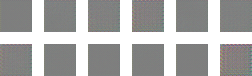

In [71]:
latent_z=convert(array_type,randn(latent_size,12))
im=G(latent_z)
im=im.+1
im./=2
imshow(im)

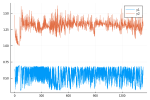

In [49]:
using Plots
plot(G_losses)
plot!(D_losses)

In [ ]:

w=rand(3,3)